In [1]:
import copy
import multiprocessing as mp
from pathlib import Path
import random
import sys
from typing import Optional

import datamol as dm
import lohi_splitter as lohi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polaris as po
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
import seaborn as sns
from splito._scaffold_split import get_scaffold
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

sys.path.append('../src')
from utils import ECFP_from_smiles, tanimoto_similarity, standardize_smiles

[14:52:58] Initializing Normalizer


In [2]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
benchmark = po.load_benchmark("polaris/adme-fang-solu-1")

2024-06-21 14:52:59.614 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-21 14:52:59.623 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [4]:
train = pd.read_csv('~/data/train.tsv', sep='\t')
test = pd.read_csv('~/data/test.tsv', sep='\t')

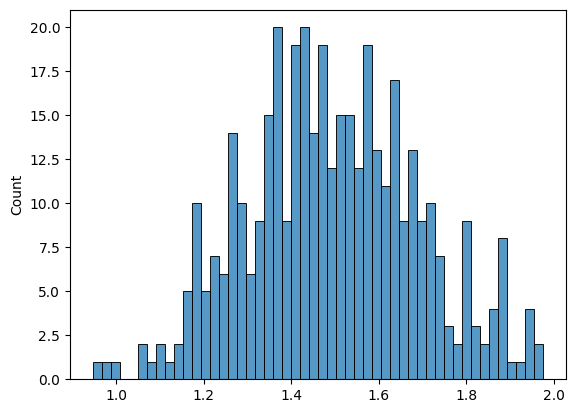

In [5]:
y_pred = 0.2 * np.random.randn(len(test)) + 1.5
sns.histplot(y_pred, bins=50);

In [6]:
results = benchmark.evaluate(y_pred)
results

{
  "name": null,
  "description": "",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "adme-fang-SOLU-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/adme-fang-solu-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_absolute_error",
      "Score": 0.5199767201
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_squared_error",
      "Score": 0.6536645301
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "r2",
      "Score": -0.2056257511
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "spearmanr",
      "Score": -0.0098429035
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "pearsonr",
      "Score": -0.0118886754
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "explained_var",
      "Score": -0.0784179963
    }
  ]
}

In [7]:
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd

In [8]:
def renumerate_smiles(smiles):
    """Perform a randomization of a SMILES string
    must be RDKit sanitizable"""
    m = Chem.MolFromSmiles(smiles)
    ans = list(range(m.GetNumAtoms()))
    np.random.shuffle(ans)
    nm = Chem.RenumberAtoms(m,ans)
    smiles = Chem.MolToSmiles(nm, canonical=False, isomericSmiles=True)

    return smiles

class TransformersTokenizer:
    def __init__(self, pretrained_model_name_or_path, max_length, padding, truncation, do_lower_case) -> None:
        if pretrained_model_name_or_path == 'ibm/MoLFormer-XL-both-10pct':
            self.tokenizer = AutoTokenizer.from_pretrained(
                pretrained_model_name_or_path, do_lower_case=do_lower_case, trust_remote_code=True
            )
        else:
            print(f'Loading an unknown tokenizer: {pretrained_model_name_or_path}')
            self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path, use_fast=False, max_len=128)
        self.max_length = max_length
        self.padding = padding
        self.truncation = truncation

    def tokenize(self, seq: str) -> tuple[list[int], list[int]]:
        raise NotImplementedError()

    @property
    def pad_token_id(self) -> int:
        return self.tokenizer.pad_token_id


class MolTransformersTokenizer(TransformersTokenizer):
    def __init__(self, pretrained_model_name_or_path, max_length=128, padding=False, truncation=True) -> None:
        super().__init__(
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            max_length=max_length,
            padding=padding,
            truncation=truncation,
            do_lower_case=False
        )

    def tokenize(self, smiles: str) -> tuple[list[int], list[int]]:
        tokenized = self.tokenizer(smiles, max_length=self.max_length,
                                   padding=self.padding, truncation=self.truncation)
        
        return tokenized['input_ids'], tokenized['attention_mask']


class BasicTokenizationDataset(Dataset):
    def __init__(self, data: pd.DataFrame, tokenizer: TransformersTokenizer, smiles_col: str,
                 randomize_smiles: bool = False, label_col: Optional[str] = None, truncate: bool = False) -> None:
        super().__init__()
        self.data = data
        self.smiles_col = smiles_col
        self.randomize_smiles = randomize_smiles
        self.label_col = label_col
        self.tokenizer = tokenizer
        self.truncate = truncate

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
        smiles = self.data.iloc[index][self.smiles_col]

        if self.randomize_smiles and np.random.rand() > 0.5:
            smiles = renumerate_smiles(smiles)

        if self.label_col is not None:
            label = torch.tensor(self.data.iloc[index][self.label_col], dtype=torch.float32)
        input_ids, attention_mask = self.tokenizer.tokenize(smiles)

        sample = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        if self.label_col is not None:
            sample['label'] = label

        return sample

    def collate_fn(self, samples):
        input_ids = [sample['input_ids'] for sample in samples]
        attention_mask = [sample['attention_mask'] for sample in samples]
        input_ids, attention_mask = BasicTokenizationDataset.pad_sequences(
            input_ids, attention_mask, self.tokenizer.pad_token_id
        )

        batch = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        if self.label_col is not None:
            batch['label'] = torch.stack([sample['label'] for sample in samples])

        return batch

    @staticmethod
    def pad_sequences(input_ids, attention_mask, pad_token_id=0):
        max_seq_len = max([len(inp) for inp in input_ids])
        input_ids_ = torch.full((len(input_ids), max_seq_len), pad_token_id, dtype=torch.long)
        attention_mask_ = torch.zeros((len(input_ids), max_seq_len), dtype=torch.bool)
        for i, (inp, att_mask) in enumerate(zip(input_ids, attention_mask)):
            input_ids_[i, :len(inp)] = torch.tensor(inp, dtype=torch.long)
            attention_mask_[i, :len(att_mask)] = torch.tensor(att_mask, dtype=torch.long)

        return input_ids_, attention_mask_

In [9]:
tokenizer = MolTransformersTokenizer("ibm/MoLFormer-XL-both-10pct", max_length=128)
train_dataset = BasicTokenizationDataset(train, tokenizer, randomize_smiles=True, smiles_col='smiles', label_col='logS')
test_dataset = BasicTokenizationDataset(test, tokenizer, smiles_col='smiles')
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset.collate_fn)

In [10]:
class Model(nn.Module):
    def __init__(self, model_name_or_path: str, num_classes: int) -> None:
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name_or_path, trust_remote_code=True)
        self.linear1 = nn.Linear(self.model.config.hidden_size, 512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids, attention_mask)
        x = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).type(torch.bool)
        x[~input_mask_expanded] = torch.finfo(torch.float16).min  # Set padding tokens to large negative value
        feats_max_pool = F.max_pool1d(x.permute(0, 2, 1), kernel_size=x.size(1)).squeeze(-1)

        x = self.linear1(feats_max_pool)
        logits = self.classifier(x)

        return logits

In [ ]:
torch.set_grad_enabled(True)

N_EPOCHS = 30
train_losses = []
best_model = None
best_r2 = -np.inf
best_results = None
best_predictions = None

model = Model('ibm/MoLFormer-XL-both-10pct', 1)
model = model.cuda()
criteria = nn.MSELoss()
# criteria = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=1e-4, steps_per_epoch=len(train_dataloader), epochs=N_EPOCHS
# )

for epoch in range(N_EPOCHS):
    model.train()
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        batch = {k: v.cuda() for k, v in batch.items()}
        output = model(batch['input_ids'], batch['attention_mask']).squeeze(-1)
        loss = criteria(output, batch['label'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        loss_val = loss.item()
        train_losses.append(loss_val)
        epoch_losses.append(loss_val)
    
    print(f'Epoch: {epoch}, Train Loss: {np.mean(epoch_losses)}')
    epoch_losses = []

    model.eval()
    predictions = []
    for batch in test_dataloader:
        batch = {k: v.cuda() for k, v in batch.items()}
        with torch.no_grad():
            output = model(batch['input_ids'], batch['attention_mask']).squeeze(-1)
        predictions.append(output.detach().cpu().numpy())
    predictions = np.concatenate(predictions)
    
    results = benchmark.evaluate(predictions)
    metrics = results.results
    print(metrics)

    r2 = metrics['Score'].iloc[2]

    if r2 > best_r2:
        best_r2 = r2
        best_model = copy.deepcopy(model.state_dict())
        best_results = results
        best_predictions = predictions

In [ ]:
best_results

In [ ]:
model = Model('ibm/MoLFormer-XL-both-10pct', 1)
model = model.cuda()
model.load_state_dict(best_model)
model.eval()
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset.collate_fn)
predictions = []
for batch in test_dataloader:
    batch = {k: v.cuda() for k, v in batch.items()}
    with torch.no_grad():
        output = model(batch['input_ids'], batch['attention_mask']).squeeze(-1)
    predictions.append(output.detach().cpu().numpy())
predictions = np.concatenate(predictions)

results = benchmark.evaluate(predictions)
metrics = results.results
print(metrics)

In [69]:
benchmark = po.load_benchmark("polaris/adme-fang-solu-1")
results = benchmark.evaluate(best_predictions)
results.name = 'it-works-now'
results.description = 'We asked LLM to predict solubility'
results

2024-06-21 14:42:28.963 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-21 14:42:28.976 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


{
  "name": "it-works-now",
  "description": "We asked LLM to predict solubility",
  "tags": [],
  "user_attributes": {},
  "owner": null,
  "polaris_version": "dev",
  "benchmark_name": "adme-fang-SOLU-1",
  "benchmark_owner": {
    "slug": "polaris",
    "external_id": "org_2gtoaJIVrgRqiIR8Qm5BnpFCbxu",
    "type": "organization"
  },
  "github_url": null,
  "paper_url": null,
  "contributors": null,
  "artifact_id": null,
  "benchmark_artifact_id": "polaris/adme-fang-solu-1",
  "results": [
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_absolute_error",
      "Score": 0.37792651
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "mean_squared_error",
      "Score": 0.3142760628
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "r2",
      "Score": 0.4203459163
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "spearmanr",
      "Score": 0.5743050623
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "pearsonr",
      "Score": 0.6693674969
    },
    {
      "Test set": "test",
      "Target label": "LOG_SOLUBILITY",
      "Metric": "explained_var",
      "Score": 0.4304849516
    }
  ]
}

In [70]:
results.upload_to_hub(owner='vladvin');

2024-06-21 14:42:31.035 | SUCCESS  | polaris.hub.client:upload_results:492 - Your result has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/polaris/adme-fang-SOLU-1/VpFQiX34TErHXhN7QRkQC
